依赖

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 读取 ETTh1 数据
df = pd.read_csv('./../datasets/ETTh1.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

data_parser = {
    'ETTh1':{'data':'ETTh1.csv', 'data_dim':7, 'split':[12*30*24, 4*30*24, 4*30*24]},
    'ETTm1':{'data':'ETTm1.csv', 'data_dim':7, 'split':[4*12*30*24, 4*4*30*24, 4*4*30*24]},
    'WTH':{'data':'WTH.csv', 'data_dim':12, 'split':[28*30*24, 10*30*24, 10*30*24]},
    'ECL':{'data':'ECL.csv', 'data_dim':321, 'split':[15*30*24, 3*30*24, 4*30*24]},
    'ILI':{'data':'national_illness.csv', 'data_dim':7, 'split':[0.7, 0.1, 0.2]},
    'Traffic':{'data':'traffic.csv', 'data_dim':862, 'split':[0.7, 0.1, 0.2]},
}

train_size = data_parser['ETTh1']['split'][0]
val_size = data_parser['ETTh1']['split'][1]
test_size = data_parser['ETTh1']['split'][2]

# 仅使用 OT（负载）这一列
series = df['OT']


可视化

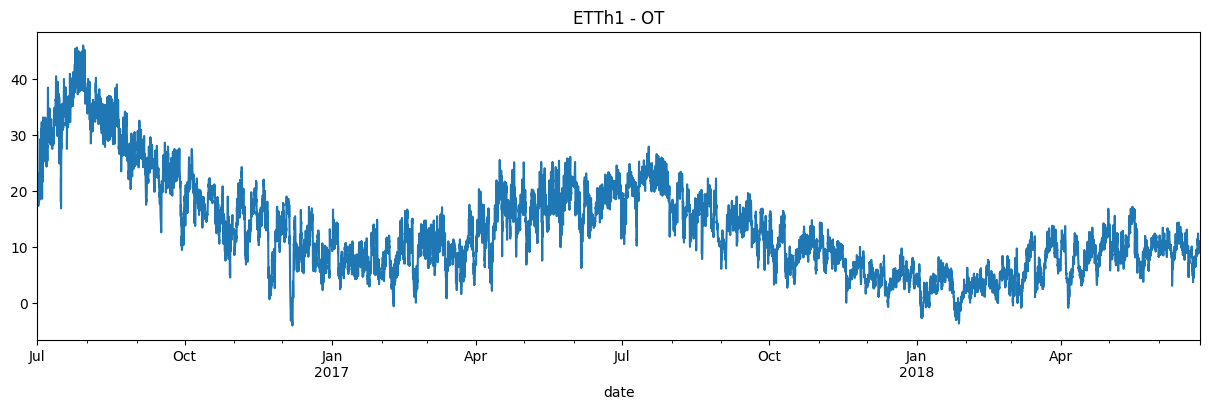

In [ ]:
series.plot(figsize=(15, 4), title='ETTh1 - OT')
plt.show()

若 p-value < 0.05，序列可认为是平稳的。

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.487963577593456
p-value: 0.008301649485463957


划分数据集

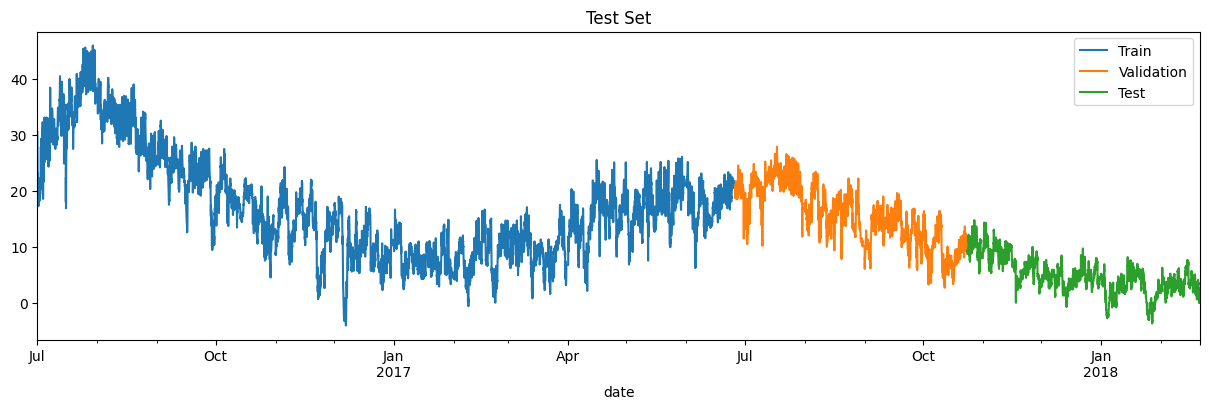

In [17]:
train, val, test = series[:train_size], series[train_size:train_size+val_size], series[train_size+val_size:train_size+val_size+test_size]
train.plot(figsize=(15, 4), title='Train Set')
val.plot(figsize=(15, 4), title='Validation Set')
test.plot(figsize=(15, 4), title='Test Set')
plt.legend(['Train', 'Validation', 'Test'])

自动选择 ARIMA 参数

In [12]:
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

#  ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25493.605, Time=6.49 sec


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25667.214, Time=2.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25679.859, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25680.226, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25680.279, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25677.869, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25679.715, Time=1.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25680.350, Time=1.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25661.056, Time=4.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25669.989, Time=1.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=25502.985, Time=6.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25493.605, Time=6.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25663.663, Time=0.64 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=25495.488, Time=6.70 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25672.346, Time=0.41 sec
 ARIMA(5,1,0)(0,0,0

训练 ARIMA 模型

In [13]:
model = ARIMA(train, order=(4, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\ASUS\anaconda3\envs\crossformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\crossformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\crossformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\crossformer\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\anaconda3\envs\crossformer\lib\site-packages\statsmodels

                               SARIMAX Results                                
Dep. Variable:                     OT   No. Observations:                 8640
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -12739.842
Date:                Wed, 14 May 2025   AIC                          25491.683
Time:                        00:40:52   BIC                          25534.068
Sample:                    07-01-2016   HQIC                         25506.135
                         - 06-25-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9530      0.007    138.887      0.000       0.940       0.966
ar.L2          0.0307      0.009      3.284      0.001       0.012       0.049
ar.L3          0.0168      0.011      1.590      0.1

Test RMSE: 0.8712


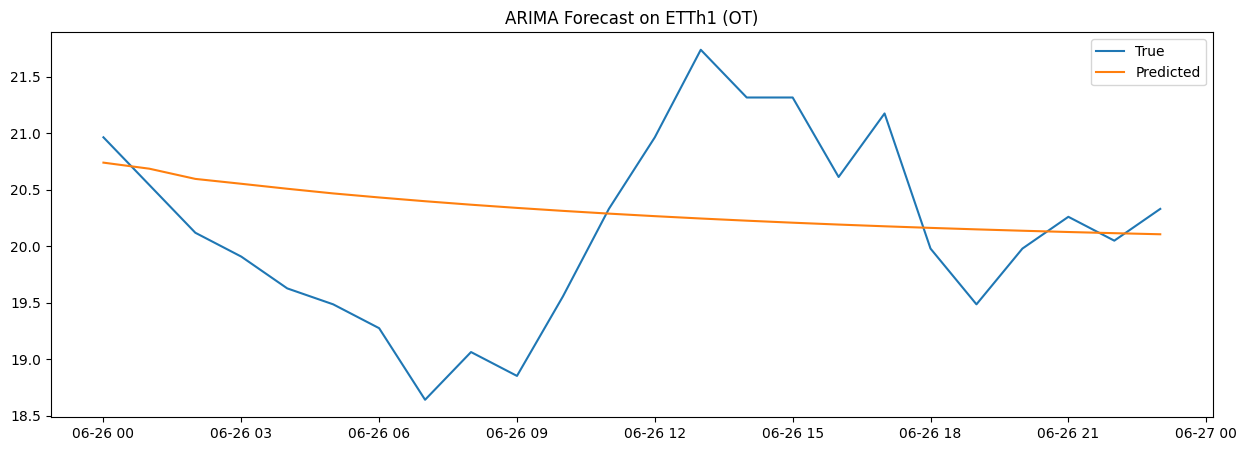

In [19]:
# 预测长度与测试集相同
val = val[:24]
forecast = model_fit.forecast(steps=len(val))
rmse = mean_squared_error(val, forecast, squared=False)
print(f"Test RMSE: {rmse:.4f}")

plt.figure(figsize=(15, 5))
plt.plot(val.index, val, label='True')
plt.plot(val.index, forecast, label='Predicted')
plt.legend()
plt.title("ARIMA Forecast on ETTh1 (OT)")
plt.show()

## 滑动窗口 + 滚动预测

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# 忽略收敛警告
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# 读取数据
df = pd.read_csv('./../datasets/ETTh1.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
series = df['OT'].replace([np.inf, -np.inf], np.nan).dropna()

# 设置窗口参数
in_len = 168
out_len = 24

# 开始滑动窗口预测
start_points = range(0, 10 * 24, 24)
predictions = []
ground_truths = []

for start in start_points:
    input_window = series[start:start + in_len].copy()
    true_future = series[start + in_len:start + in_len + out_len]
    
    # 对每个窗口尝试不同的 ARIMA 参数
    orders = [(5,1,2), (4,1,1), (3,1,0), (2,1,2)]
    
    history = input_window.tolist()
    pred = []
    for step in range(out_len):
        # 尝试不同的参数组合，直到找到收敛的模型
        model_fit = None
        for order in orders:
            try:
                model = ARIMA(history, order=order)
                model_fit = model.fit(method='css-mle', disp=0)  # 使用CSS-MLE方法
                break  # 如果成功则跳出循环
            except:
                continue
                
        if model_fit is None:
            print(f"Failed to fit ARIMA model for start point {start} with input window {input_window.index}")
            break
        yhat = model_fit.forecast()[0]
            
        pred.append(yhat)
        history.append(yhat)

    predictions.append(pred)
    ground_truths.append(true_future.values)

# 计算 RMSE
rmses = [mean_squared_error(gt, pred, squared=False) for gt, pred in zip(ground_truths, predictions)]
print(f'Average RMSE over {len(start_points)} samples: {np.mean(rmses):.4f}')

# 可视化预测结果
plt.figure(figsize=(15, 8))
for i in range(min(3, len(start_points))):  # 展示前3个预测结果
    plt.subplot(3, 1, i+1)
    start = start_points[i]
    actual_start_time = series.index[start + in_len]
    actual_end_time = series.index[start + in_len + out_len - 1]
    
    plt.plot(range(out_len), ground_truths[i], 'b-', label='ground truth')
    plt.plot(range(out_len), predictions[i], 'r-', label='prediction')
    plt.legend()
    
plt.tight_layout()
plt.show()

Failed to fit ARIMA model for start point 0 with input window DatetimeIndex(['2016-07-01 00:00:00', '2016-07-01 01:00:00',
               '2016-07-01 02:00:00', '2016-07-01 03:00:00',
               '2016-07-01 04:00:00', '2016-07-01 05:00:00',
               '2016-07-01 06:00:00', '2016-07-01 07:00:00',
               '2016-07-01 08:00:00', '2016-07-01 09:00:00',
               ...
               '2016-07-07 14:00:00', '2016-07-07 15:00:00',
               '2016-07-07 16:00:00', '2016-07-07 17:00:00',
               '2016-07-07 18:00:00', '2016-07-07 19:00:00',
               '2016-07-07 20:00:00', '2016-07-07 21:00:00',
               '2016-07-07 22:00:00', '2016-07-07 23:00:00'],
              dtype='datetime64[ns]', name='date', length=168, freq=None)
Failed to fit ARIMA model for start point 24 with input window DatetimeIndex(['2016-07-02 00:00:00', '2016-07-02 01:00:00',
               '2016-07-02 02:00:00', '2016-07-02 03:00:00',
               '2016-07-02 04:00:00', '2016-07-02

ValueError: Found input variables with inconsistent numbers of samples: [24, 0]